In [9]:
%matplotlib inline
%time from hikyuu.interactive.interactive import *
use_draw_engine('matplotlib')
#use_draw_engine('echarts')

Wall time: 1.01 ms


# 一、策略分析

## 原始描述

建仓条件：expma周线exp1跟exp2金叉向上使用使用 B=50% 的资金买入股票，建仓成功后，卖出条件才能起作用

卖出条件S1：expma日线exp1和exp2死叉向下时卖出持仓股 S=50%

买入条件B1：expma日线exp1和exp2金叉向上时买入股票数为S（卖出条件S1卖出股数）

S1和B1就这样循环

清仓条件为：expma周线exp1和exp2死叉时


## 策略分析

市场环境：无

系统有效性：周线EMA1（快线）和EMA2（慢线）金叉向上直到两者死叉，系统有效时建立初始仓位

信号指示器：
- 买入：日线EMA1（快线）和EMA2（慢线）金叉向上
- 卖出：日线EMA1（快线）和EMA2（慢线）死叉向下

止损/止盈：无

资金管理：
- 初次建仓：使用50%的资金
- 买入：初次建仓时持股数的50%
- 卖出：初次建仓时持股数的50%

盈利目标：无


# 二、实现系统部件

## 自定义系统有效性策略

In [10]:
def getNextWeekDateList(week):
    from datetime import timedelta
    py_week = week.datetime()
    next_week_start = py_week + timedelta(days = 7 - py_week.weekday())
    next_week_end = next_week_start + timedelta(days=5)
    return getDateRange(Datetime(next_week_start), Datetime(next_week_end))
#ds = getNextWeekDateList(Datetime(201801010000))
#for d in ds:
#    print(d)

In [11]:
def DEMO_CN(self):
    """ DIF > DEA 时，系统有效
    参数：
    fast_n：周线dif窗口
    slow_n: 周线dea窗口
    """
    k = self.getTO()
    if (len(k) <= 1):
        return
    
    #-----------------------------
    # 周线        
    #-----------------------------
    week_q = QueryByDate(k[0].datetime, k[-1].datetime, kType=Query.WEEK)
    week_k = k.getStock().getKData(week_q)
    
    n1 = self.getParam("week_macd_n1")
    n2 = self.getParam("week_macd_n2")
    n3 = self.getParam("week_macd_n3")
    m = MACD(CLOSE(week_k), n1, n2, n3)
    fast = m.getResult(0)
    slow = m.getResult(1)

    x = fast > slow
    for i in range(x.discard, len(x)-1):
        if (x[i] >= 1.0):
            #需要被扩展到日线（必须是后一周）
            date_list = getNextWeekDateList(week_k[i].datetime)
            for d in date_list:
                self._addValid(d)

## 自定义信号指示器

In [12]:
#这个例子不需要，已经有内建的SG_Cross函数可直接使用

## 自定义资金管理策略

In [13]:
class DEMO_MM(MoneyManagerBase):
    """
    初次建仓：使用50%的资金
    买入：初次建仓时持股数的50%
    卖出：初次建仓时持股数的50%
    """
    def __init__(self):
        super(DEMO_MM, self).__init__("MACD_MM")
        self.setParam("init_position", 0.5) #自定义初始仓位参数，占用资金百分比
        self.next_buy_num = 0
        
    def _reset(self):
        self.next_buy_num = 0
        #pass
        
    def _clone(self):
        mm = DEMO_MM()
        mm.next_buy_num = self.next_buy_num
        #return DEMO_MM()
    
    def _getBuyNumber(self, datetime, stk, price, risk, part_from):
        tm = self.getTM()
        cash = tm.currentCash
        
        #如果信号来源于系统有效条件，建立初始仓位
        if part_from == System.Part.CONDITION:
            #return int((cash * 0.5 // price // stk.atom) * stk.atom)  #MoneyManagerBase其实已经保证了买入是最小交易数的整数
            self.next_buy_num = 0 #清理掉上一周期建仓期间滚动买卖的股票数
            return int(cash * self.getParam("init_position") // price)
        
        #非初次建仓，买入同等数量
        return self.next_buy_num
    
    def _getSellNumber(self, datetime, stk, price, risk, part_from):
        tm = self.getTM()
        position = tm.getPosition(stk)
        current_num = int(position.number * 0.5)
        
        #记录第一次卖出时的股票数，以便下次以同等数量买入
        if self.next_buy_num == 0:
            self.next_buy_num = current_num 
            
        return current_num #返回类型必须是整数

# 三、构建并运行系统

## 修改设定公共参数

每个系统部件以及TradeManager都有自己的公共参数会影响系统运行，具体可以查看帮助及试验。

比如：这个例子当前使用系统有效条件进行初始建仓，那么必须设置系统公共参数cn_open_position为True。否则，没有建立初始仓位的话，后续没有卖出，不会有任何交易。

In [14]:
#System参数
#delay=True #(bool) : 是否延迟到下一个bar开盘时进行交易
#delay_use_current_price=True #(bool) : 延迟操作的情况下，是使用当前交易时bar的价格计算新的止损价/止赢价/目标价还是使用上次计算的结果
#max_delay_count=3 #(int) : 连续延迟交易请求的限制次数
#tp_monotonic=True #(bool) : 止赢单调递增
#tp_delay_n=3 #(int) : 止盈延迟开始的天数，即止盈策略判断从实际交易几天后开始生效
#ignore_sell_sg=False #(bool) : 忽略卖出信号，只使用止损/止赢等其他方式卖出
#ev_open_position=False #(bool): 是否使用市场环境判定进行初始建仓

cn_open_position=True #(bool): 是否使用系统有效性条件进行初始建仓

#MoneyManager公共参数
#auto-checkin=False #(bool) : 当账户现金不足以买入资金管理策略指示的买入数量时，自动向账户中补充存入（checkin）足够的现金。
#max-stock=20000 #(int) : 最大持有的证券种类数量（即持有几只股票，而非各个股票的持仓数）
#disable_ev_force_clean_position=False #(bool) : 禁用市场环境失效时强制清仓
#disable_cn_force_clean_position=False #(bool) : 禁用系统有效条件失效时强制清仓


## 设定私有参数及待测试标的

In [15]:
#账户参数
init_cash = 500000 #账户初始资金
init_date = '1990-1-1' #账户建立日期

#信号指示器参数
week_n1 = 12
week_n2 = 26
week_n3 = 9

#选定标的，及测试区间
stk = sm['sz000002']

#如果是同一级别K线，可以使用索引号，使用了不同级别的K线数据，建议还是使用日期作为参数
#另外，数据量太大的话，matplotlib绘图会比较慢
start_date = Datetime('2016-01-01')  
end_date = Datetime()

## 构建系统实例

In [16]:
#创建模拟交易账户进行回测，初始资金30万
my_tm = crtTM(datetime=Datetime(init_date), initCash = init_cash)

#创建系统实例
my_sys = SYS_Simple()

my_sys.setParam("cn_open_position", cn_open_position)

my_sys.tm = my_tm
my_sys.cn = crtCN(DEMO_CN, 
              {'week_macd_n1': week_n1, 'week_macd_n2': week_n2, 'week_macd_n3': week_n3}, 
                'DEMO_CN')  
my_sys.sg = SG_Cross(EMA(n=week_n1), EMA(n=week_n2))
my_sys.mm = DEMO_MM()

## 运行系统

In [17]:
q = QueryByDate(start_date, end_date, kType=Query.DAY)
my_sys.run(stk, q)

#将交易记录及持仓情况，保存在临时目录，可用Excel查看
#临时目录一般设置在数据所在目录下的 tmp 子目录
#如果打开了excel记录，再次运行系统前，记得先关闭excel文件，否则新的结果没法保存
my_tm.tocsv(sm.tmpdir())

# 四、查看资金曲线及绩效统计

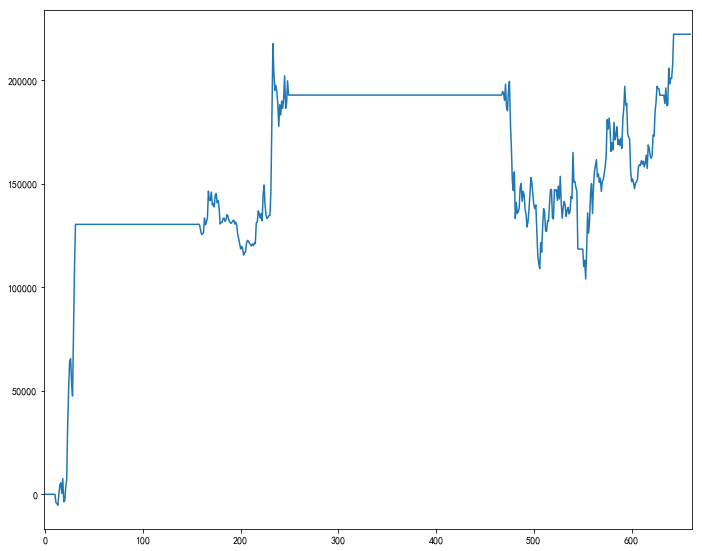

In [18]:
#绘制资金收益曲线
x = my_tm.getProfitCurve(stk.getDatetimeList(q), KQuery.DAY)
#x = my_tm.getFundsCurve(stk.getDatetimeList(q), KQuery.DAY) #资金净值曲线
PRICELIST(x).plot()

In [19]:
#回测统计
per = Performance()
print(per.report(my_tm, Datetime.now()))

帐户初始金额: 500000.00
累计投入本金: 500000.00
累计投入资产: 0.00
累计借入现金: 0.00
累计借入资产: 0.00
累计红利: 0.00
现金余额: 722279.50
未平仓头寸净值: 0.00
当前总资产: 722279.50
已平仓交易总成本: 0.00
已平仓净利润总额: 222279.50
单笔交易最大占用现金比例%: 49.94
交易平均占用现金比例%: 43.77
已平仓帐户收益率%: 44.46
帐户年复合收益率%: 14.67
帐户平均年收益率%: 16.54
赢利交易赢利总额: 296681.50
亏损交易亏损总额: -74402.00
已平仓交易总数: 5.00
赢利交易数: 4.00
亏损交易数: 1.00
赢利交易比例%: 80.00
赢利期望值: 44455.90
赢利交易平均赢利: 74170.38
亏损交易平均亏损: -74402.00
平均赢利/平均亏损比例: 1.00
净赢利/亏损比例: 3.99
最大单笔赢利: 130416.00
最大单笔亏损: -74402.00
赢利交易平均持仓时间: 75.50
赢利交易最大持仓时间: 141.00
亏损交易平均持仓时间: 119.00
亏损交易最大持仓时间: 119.00
空仓总时间: 561.00
空仓时间/总时间%: 57.00
平均空仓时间: 112.00
最长空仓时间: 327.00
最大连续赢利笔数: 2.00
最大连续亏损笔数: 1.00
最大连续赢利金额: 192882.00
最大连续亏损金额: -74402.00
R乘数期望值: 0.15
交易机会频率/年: 1.86
年度期望R乘数: 0.28
赢利交易平均R乘数: 0.22
亏损交易平均R乘数: -0.15
最大单笔赢利R乘数: 0.52
最大单笔亏损R乘数: -0.15
最大连续赢利R乘数: 0.33
最大连续亏损R乘数: -0.15



# 五、或许想看下图形

In [20]:
#自己写吧

# 六、或许想看看所有股票的情况

In [21]:
import pandas as pd
def calTotal(blk, q):
    per = Performance()
    s_name = []
    s_code = []
    x = []
    for stk in blk:
        my_sys.run(stk, q)
        per.statistics(my_tm, Datetime.now())
        s_name.append(stk.name)
        s_code.append(stk.market_code)
        x.append(per.get("当前总资产".encode('gb2312')))
    return pd.DataFrame({'代码': s_code, '股票': s_name, '当前总资产': x})

%time data = calTotal(blocka, q)

[2019-03-27 21:40:29.664] [info] KData is empty! [System::run]
[2019-03-27 21:40:29.806] [info] KData is empty! [System::run]
[2019-03-27 21:40:29.867] [info] KData is empty! [System::run]
[2019-03-27 21:40:29.868] [info] KData is empty! [System::run]
[2019-03-27 21:40:29.949] [info] KData is empty! [System::run]
[2019-03-27 21:40:29.965] [info] KData is empty! [System::run]
[2019-03-27 21:40:30.112] [info] KData is empty! [System::run]
[2019-03-27 21:40:30.215] [info] KData is empty! [System::run]
[2019-03-27 21:40:30.517] [info] KData is empty! [System::run]
[2019-03-27 21:40:30.777] [info] KData is empty! [System::run]
[2019-03-27 21:40:30.852] [info] KData is empty! [System::run]
[2019-03-27 21:40:30.910] [info] KData is empty! [System::run]
[2019-03-27 21:40:31.147] [info] KData is empty! [System::run]
[2019-03-27 21:40:31.307] [info] KData is empty! [System::run]
[2019-03-27 21:40:31.712] [info] KData is empty! [System::run]
[2019-03-27 21:40:31.832] [info] KData is empty! [Syste

In [22]:
#保存到CSV文件
#data.to_csv(sm.tmpdir() + '/统计.csv')
data[:10]

,代码,股票,当前总资产
0,SZ000532,华金资本,469648.70
1,SH601777,力帆股份,411624.04
2,SZ300238,冠昊生物,572131.00
3,SH600781,辅仁药业,495012.25
4,SH600770,综艺股份,451413.04
5,SH600671,天目药业,408328.75
6,SZ002888,惠威科技,643861.50
7,SH600086,东方金钰,440287.42
8,SH603599,广信股份,412215.16
9,SH600363,联创光电,522211.94
